In [17]:
# Imports
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline


As observed, orders.csv contains comprehensive details regarding a specific order ID, such as the purchasing user, purchase timestamp, days elapsed since the previous order, and more.

The columns found in both order_products_train and order_products_prior are identical. So, what sets these files apart?

As previously stated, this dataset includes between 4 to 100 orders for each customer (which we'll examine later). Our goal is to forecast which products will be re-purchased. Consequently, the user's most recent order has been extracted and partitioned into training and testing sets. The historical order information for each customer can be found in the order_products_prior file. Additionally, it's worth mentioning that the orders.csv file contains an eval_set column, indicating which of the three datasets (prior, train, or test) a specific row belongs to.

In [4]:
RAW_DATA_PATH = '../data/raw/' # raw csv files
INTERIM_DATA_PATH = '../data/interim/' # cached dataframes

In [5]:
train_products = pd.read_csv(os.path.join(RAW_DATA_PATH, "order_products__train.csv"))
prior_products = pd.read_csv(os.path.join(RAW_DATA_PATH, "order_products__prior.csv"))
orders = pd.read_csv(os.path.join(RAW_DATA_PATH, "orders.csv"))
products = pd.read_csv(os.path.join(RAW_DATA_PATH, "products.csv"))

In [6]:
train_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
prior_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


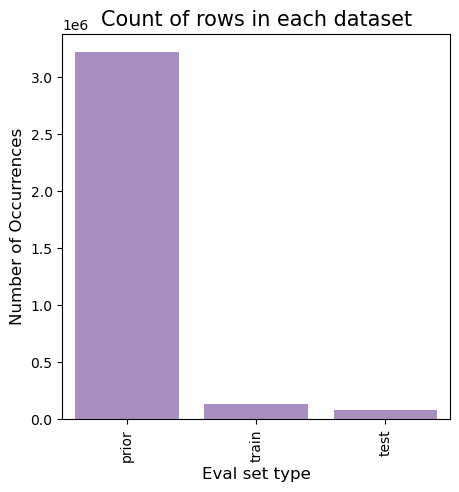

In [23]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(5,5))
# Create a bar plot
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[4])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [25]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

There are 206,209 customers in total. Out of these, the last purchase of 131,209 customers is designated as the train set. Our objective is to make predictions for the remaining 75,000 customers.

Next, we will verify the assertion that each customer is provided with between 4 to 100 orders.

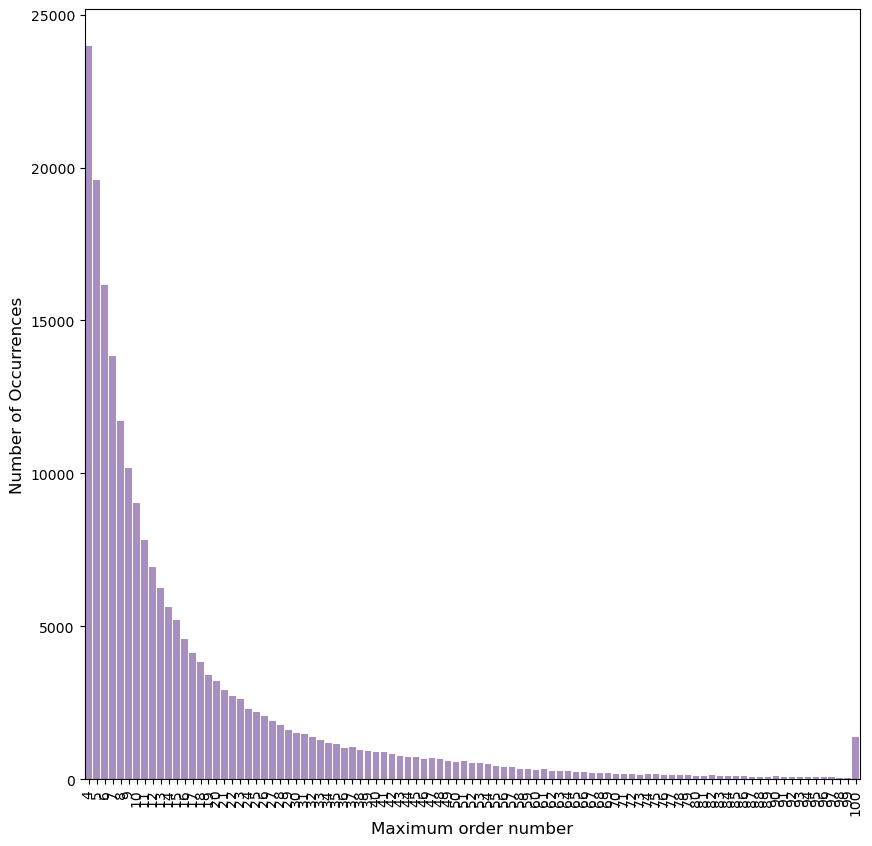

In [30]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(10,10))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[4])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Let's now examine how the pattern of ordering shifts with different days of the week.

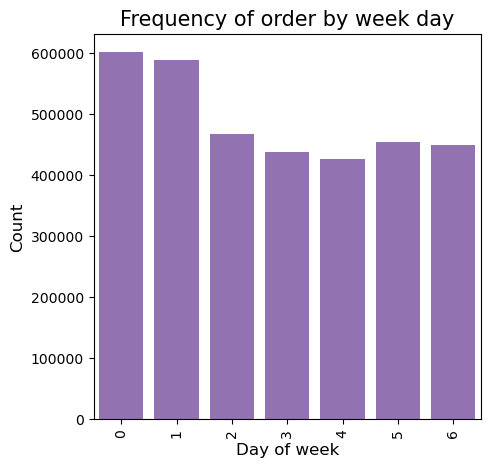

In [38]:
plt.figure(figsize=(5,5))
sns.countplot(x="order_dow", data=orders, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

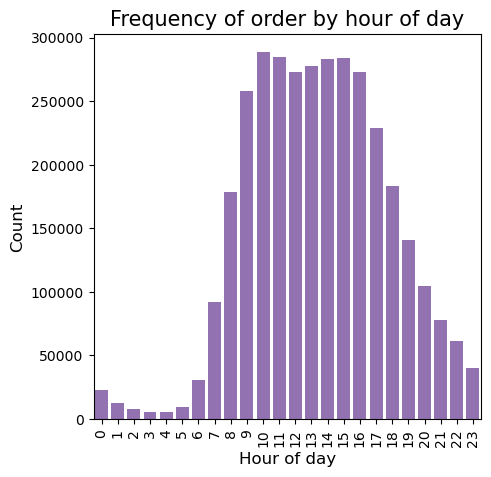

In [39]:
plt.figure(figsize=(5,5))
sns.countplot(x="order_hour_of_day", data=orders, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Now let us combine the day of week and hour of day to see the distribution.

/var/folders/h4/40rl009s0kb57zjm1tj9msth0000gn/T/ipykernel_11735/521522845.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grouped = grouped.pivot('order_dow', 'order_hour_of_day', 'order_number')


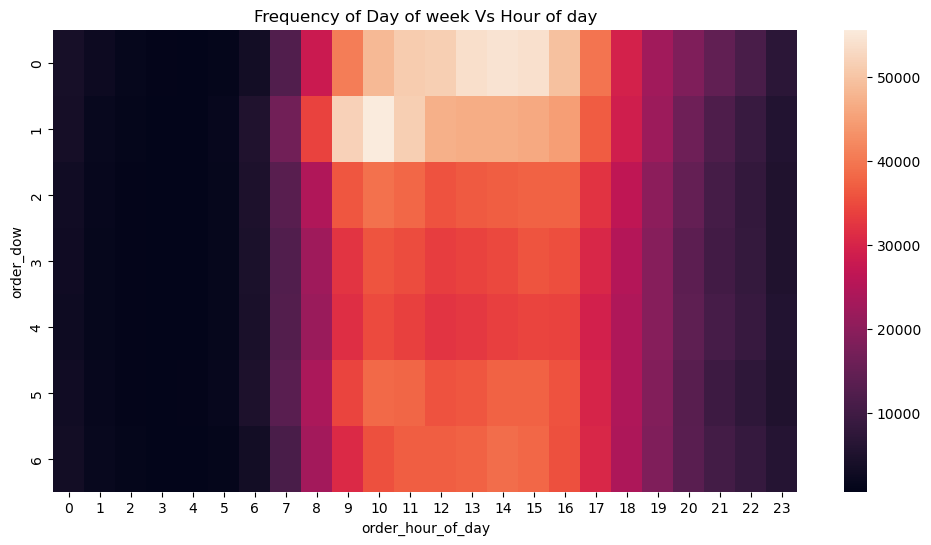

In [41]:
grouped = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped = grouped.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.

Now let us check the time interval between the orders.

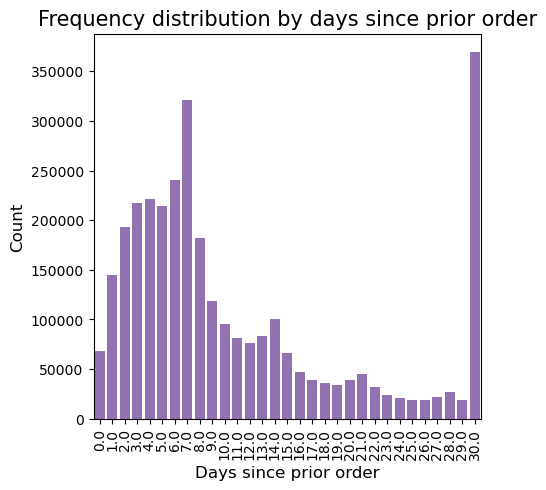

In [44]:
plt.figure(figsize=(5,5))
sns.countplot(x="days_since_prior_order", data=orders, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

It appears that customers tend to place orders approximately once a week (as indicated by the peak at 7 days) or once a month (observed at 30 days). Additionally, there are smaller peaks at 14, 21, and 28 days, indicating weekly intervals.

To achieve our goal of identifying re-orders, let's assess the re-order percentage in both the prior set and the train set.

In [55]:
# percentage of re-orders in prior set #
print(f"{(prior_products.reordered.sum() / prior_products.shape[0])*100:.4f}%")

58.9697%


Now, lets see the number of products bought in each order. It seems that it follows a right tailed distribution with the maximum value at 5.

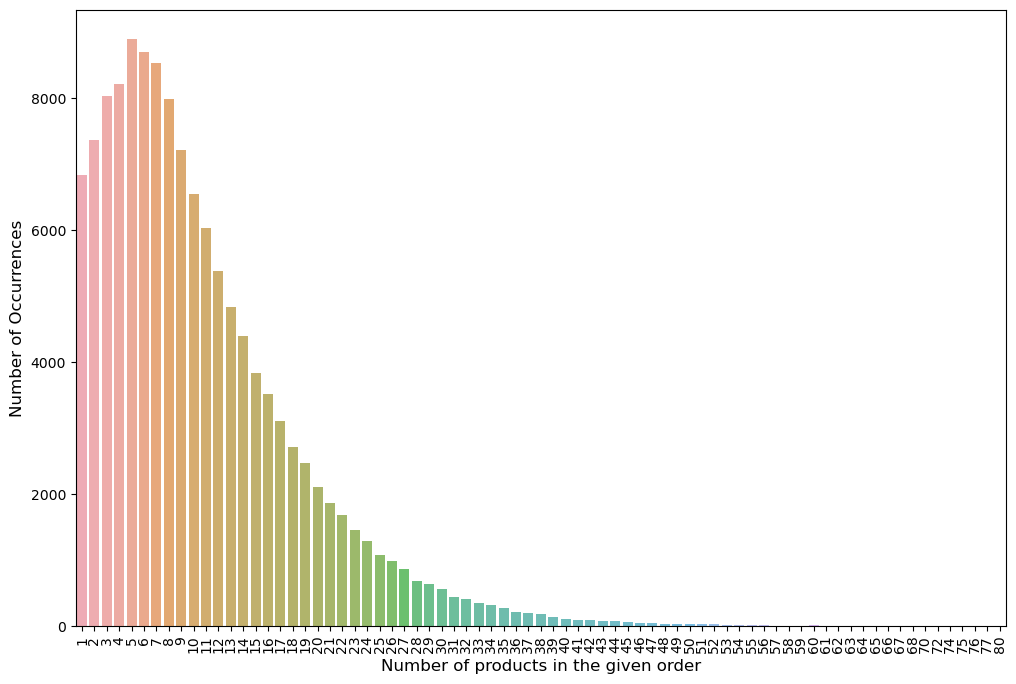

In [60]:
grouped = train_products.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We shall merge prior_products details with product details

In [65]:
prior_products = pd.merge(prior_products, products, on='product_id', how='left')
prior_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name_x,aisle_id_x,department_id_x,product_name_y,aisle_id_y,department_id_y,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16,Organic Egg Whites,86,16,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4,Michigan Organic Kale,83,4,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13,Garlic Powder,104,13,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13,Coconut Butter,19,13,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13,Natural Sweetener,17,13,Natural Sweetener,17,13


Let's look at the frequency of most ordered items

In [66]:
cnt_srs = prior_products['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


Now, let's delve into understanding how the order in which products are added to the cart influences the reordering likelihood.

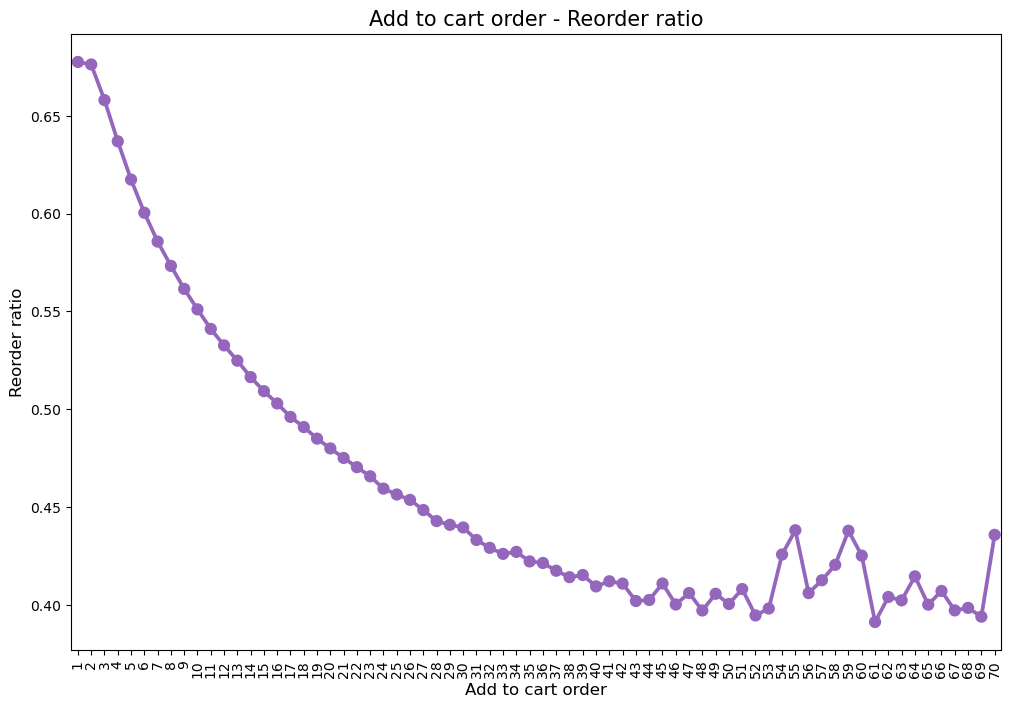

In [74]:
prior_products["add_to_cart_order_mod"] = prior_products["add_to_cart_order"].copy()
prior_products["add_to_cart_order_mod"].loc[prior_products["add_to_cart_order_mod"]>70] = 70
grouped = prior_products.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped['add_to_cart_order_mod'].values, y=grouped['reordered'].values, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

It appears that products added to the cart at the beginning are more prone to being re-ordered, in contrast to those added later. This aligns with the common behavior of prioritizing frequently purchased items first and then exploring new product options. Lets look at reorder ratio by time based variables.

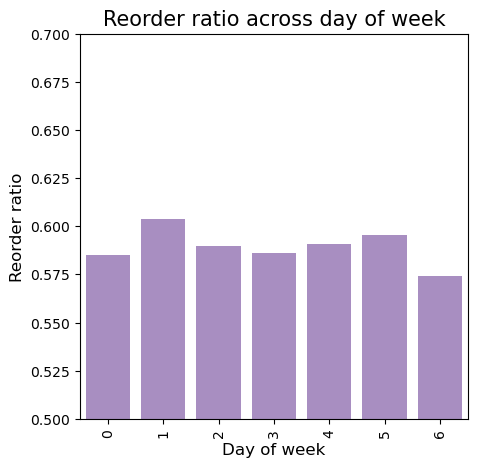

In [82]:
prior_products = pd.merge(prior_products, orders, on='order_id', how='left')
grouped = prior_products.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(5,5))
sns.barplot(x=grouped['order_dow'].values, y=grouped['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

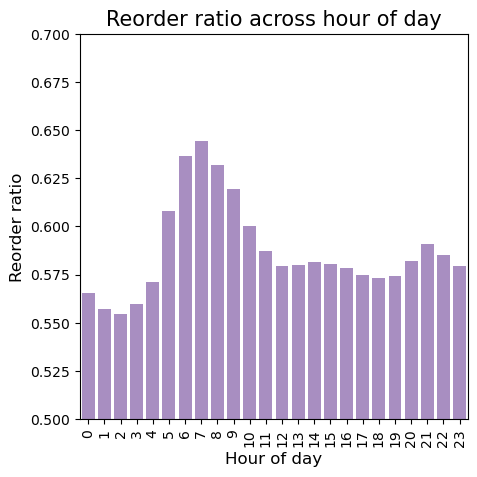

In [80]:
grouped = prior_products.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(5,5))
sns.barplot(x=grouped['order_hour_of_day'].values, y=grouped['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()